<a href="https://colab.research.google.com/github/bghata/Sentiment_Analysis/blob/master/Sentiment_Analysis_Galaxy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext rpy2.ipython

import warnings
warnings.filterwarnings('ignore')

In [0]:
%%R
install.packages("pacman")
library(pacman)

## Loading libraries

In [0]:
%%R
pacman::p_load(readr, data.table, dplyr,caret, 
               ggplot2, plotly, lubridate, kernlab,
               forecast, ggfortify, stats, tufte, 
               ggthemes, rapportools, fpp2, gbm, scatterplot3d,
               reshape2, Hmisc, rio, VIM, class, spdep, 
               randomForest, magrittr, Matrix, foreach, 
               iterators, doParallel, corrplot, C50, e1071, kknn)

## Loading data

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
%%R
galaxy_data <- read_csv('/content/gdrive/My Drive/Colab Notebooks/AWS/galaxy_smallmatrix_labeled_8d.csv')

## Feature selection

**Correlation matrix**

**on galaxy_data**

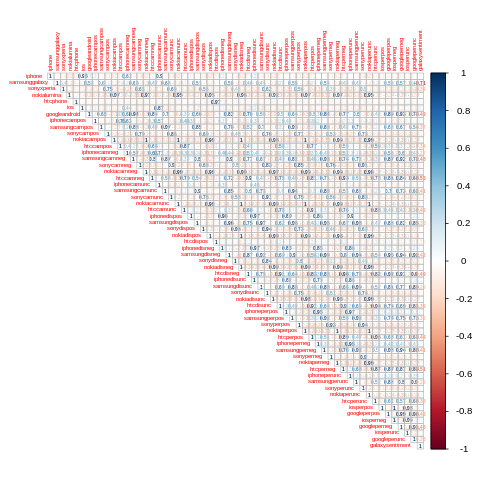

In [0]:
%%R
galaxy_cor <- cor(galaxy_data)
corrplot(cor(galaxy_cor), method="number", type = "upper", 
tl.cex = 0.5, number.cex = 0.4)

## Examine feature variance

**The distribution of values within a feature is related to how much information that feature holds in the data set. Features with no variance can be said to hold little to no information. Features that have very little, or "near zero variance", may or may not have useful information.**

In [0]:
%%R
nzvMetrics_galaxy <- nearZeroVar(galaxy_data, saveMetrics = TRUE)

**nearZeroVar() with saveMetrics = FALSE returns an vector**

In [0]:
%%R
nzv_galaxy <- nearZeroVar(galaxy_data, saveMetrics = FALSE) 

**NZV - create a new data set and remove near zero variance features**

In [0]:
%%R
galaxy_NZV <- galaxy_data[,-nzv_galaxy]
galaxy_NZV$galaxysentiment <- as.factor(galaxy_NZV$galaxysentiment)

## Recursive Feature Elimination (RFE)

**Sampling the data before using RFE**

**RFE is a form of automated feature selection. RFE with random forest will try every combination of feature subsets and return a final list of recommended features.**

**On galaxy**

In [0]:
%%R
set.seed(123)
galaxy_data$galaxysentiment <- as.factor(galaxy_data$galaxysentiment)
galaxySample <- galaxy_data[sample(1:nrow(galaxy_data), 1000, replace=FALSE),]

**Set up rfeControl with randomforest, repeated cross validation and no updates**

In [0]:
%%R
ctrl <- rfeControl(functions = rfFuncs, 
                   method = "repeatedcv",
                   repeats = 5,
                   verbose = FALSE)

**Use rfe and omit the response variable (attribute 59 iphonesentiment)**

In [0]:
%%R
rfeResults_galaxy <- rfe(galaxySample[,1:58], 
                  galaxySample$galaxysentiment, 
                  sizes=(1:58), 
                  rfeControl=ctrl)
rfeResults_galaxy

**Loading model rfeResults_iphone**

In [0]:
%%R
rfeResults_galaxy <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/rfeResults_galaxy.RDS")

**Plot results**

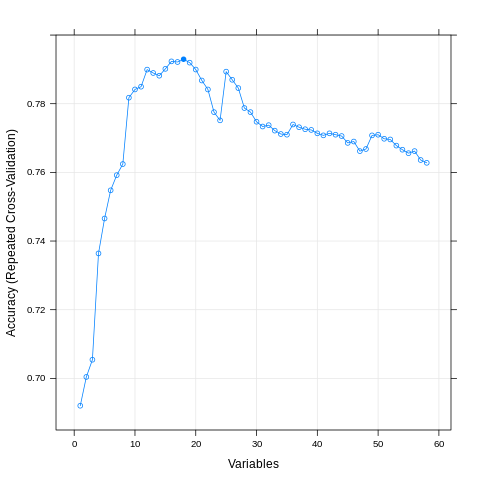

In [0]:
%%R
plot(rfeResults_galaxy, type=c("g", "o"))

**Create new data set with rfe recommended features on galaxy**

In [0]:
%%R
galaxy_RFE <- galaxy_data[, predictors(rfeResults_galaxy)]

**Add dependent variable to galaxy_RFE**

In [0]:
%%R
galaxy_RFE$galaxysentiment <- galaxy_data$galaxysentiment

# Testing 4 different models on galaxy

## Data partition on galaxy

In [0]:
%%R
trainData1 <- createDataPartition(galaxy_data$galaxysentiment,
                                p=0.70,
                                list = FALSE)
trainSet1 <- galaxy_data[trainData1, ]
testSet1 <- galaxy_data[-trainData1, ]

## Random Forest model on galaxy

In [0]:
%%R
fitControl <- trainControl(method = "repeatedcv",
                     number = 10,
                     repeats = 1)

In [0]:
rf_galaxy <- randomForest(galaxysentiment ~.,
                             data = trainSet1,
                             ntree = 100,
                             mtry = 2,
                             do.trace = TRUE,
                             trControl = fitControl,
                             imporve = 0.05,
                             nodesize = 5)

**Loading model rf_galaxy**

In [0]:
%%R
rf_galaxy <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/rf_galaxy.RDS")

**Testing Random Forest model on testSet1**

In [0]:
%%R
RF_Pred_galaxy <- predict(rf_galaxy, newdata = testSet1)
RF_CM_galaxy <- confusionMatrix(RF_Pred_galaxy, testSet1$galaxysentiment)

In [0]:
%%R
postResample(RF_Pred_galaxy, testSet1$galaxysentiment)

 Accuracy     Kappa 
0.7243507 0.4055483 


## KKNN model on galaxy

In [0]:
%%R
fitControl <- trainControl(method = "repeatedcv",
                     number = 10,
                     repeats = 1)

In [0]:
%%R
kknn_galaxy <- train(galaxysentiment ~.,
                               data = trainSet1,
                               method = 'kknn',
                               tuneLength = 5,
                               trControl = fitControl)

**Loading model kknn_galaxy**

In [0]:
%%R
kknn_galaxy <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/kknn_galaxy.RDS")

**Testing KKNN model on testSet1**

In [0]:
%%R
kknn_Pred_galaxy <- predict(kknn_galaxy, newdata = testSet1)
kknn_CM_galaxy <- confusionMatrix(kknn_Pred_galaxy, testSet1$galaxysentiment)

In [0]:
%%R
postResample(kknn_Pred_galaxy, testSet1$galaxysentiment)

 Accuracy     Kappa 
0.3623039 0.2015648 


## Gradient Boosting Trees model on galaxy

In [0]:
%%R
myGrid <- expand.grid(n.trees = c(250), 
                      interaction.depth = 1, 
                      shrinkage = c(0.1),
                      n.minobsinnode = 20

In [0]:
GB_galaxy <- train((galaxysentiment ~ .), 
                      data = trainSet1, 
                      method = "gbm",
                      trControl = fitControl,
                      tuneGrid = myGrid)

**Loading model GB_galaxy**

In [0]:
%%R
GB_galaxy <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/GB_galaxy.RDS")

**Testing Gradient Boosting Trees model on testSet1**

In [0]:
%%R
GB_Pred_galaxy <- predict(GB_galaxy, newdata = testSet1)
GB_CM_galaxy <- confusionMatrix(GB_Pred_galaxy, testSet1$galaxysentiment)

In [0]:
%%R
postResample(GB_Pred_galaxy, testSet1$galaxysentiment)

 Accuracy     Kappa 
0.7729493 0.5416980 


## SVM model on galaxy

In [0]:
%%R
fitControl <- trainControl(method = "repeatedcv",
                           number = 10,
                           repeats = 3,
                           verboseIter = T)

In [0]:
%%R
svm_galaxy <- train(galaxysentiment ~., data = trainSet1,
              method = "svmLinear",
              trControl= fitControl,
              preProcess = c("center", "scale"))

**Loading model svm_galaxy**

In [0]:
%%R
svm_galaxy <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/svm_galaxy.RDS")

**Testing SVM model on testSet1**

In [0]:
%%R
SVM_Pred_galaxy <- predict(svm_galaxy, newdata = testSet1)
SVM_CM_galaxy <- confusionMatrix(SVM_Pred_galaxy, testSet1$galaxysentiment)

In [0]:
%%R
postResample(SVM_Pred_galaxy, testSet1$galaxysentiment)

 Accuracy     Kappa 
0.7446644 0.4670412 


# Testing all 4  models on galaxy_NZV

## Data partition on galaxy_NZV

In [0]:
%%R
trainData2 <- createDataPartition(galaxy_NZV$galaxysentiment,
                                  p=0.70,
                                  list = FALSE)
trainSet2 <- galaxy_NZV[trainData2, ]
testSet2 <- galaxy_NZV[-trainData2, ]

## Random Forest model on galaxy_NZV

In [0]:
%%R
fitControl <- trainControl(method = "repeatedcv",
                           number = 10,
                           repeats = 1)

In [0]:
%%R
rf_galaxy_NZV <- randomForest(galaxysentiment ~.,
                          data = trainSet2,
                          ntree = 100,
                          mtry = 2,
                          do.trace = TRUE,
                          trControl = fitControl,
                          imporve = 0.05,
                          nodesize = 5)

**Loaading model rf_galaxy_NZV**

In [0]:
%%R
rf_galaxy_NZV <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/rf_galaxy_NZV.RDS")

**Testing Random Forest model on testSet2**

In [0]:
%%R
RF_Pred_galaxy_NZV <- predict(rf_galaxy_NZV, newdata = testSet2)
RF_CM_galaxy_NZV <- confusionMatrix(RF_Pred_galaxy_NZV, testSet2$galaxysentiment)

In [0]:
%%R
postResample(RF_Pred_galaxy_NZV, testSet2$galaxysentiment)

 Accuracy     Kappa 
0.7865775 0.5678049 


## Gradient Boosting Trees model on galaxy_NZV 

In [0]:
%%R
myGrid <- expand.grid(n.trees = c(250), 
                      interaction.depth = 1, 
                      shrinkage = c(0.1),
                      n.minobsinnode = 20)

In [0]:
%%R
GB_galaxy_NZV <- train((galaxysentiment ~ .), 
                   data = trainSet2, 
                   method = "gbm",
                   trControl = fitControl,
                   tuneGrid = myGrid)

In [0]:
%%R
GB_galaxy_NZV <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/GB_galaxy_NZV.RDS")

**Testing Gradient Boosting Trees model on testSet2**

In [0]:
%%R
GB_Pred_galaxy_NZV <- predict(GB_galaxy_NZV, newdata = testSet2)
GB_CM_galaxy_NZV <- confusionMatrix(GB_Pred_galaxy_NZV, testSet2$galaxysentiment)

In [0]:
%%R
postResample(GB_Pred_galaxy_NZV, testSet2$galaxysentiment)

 Accuracy     Kappa 
0.7490357 0.4846856 


## SVM model on galaxy_NZV

In [0]:
%%R
fitControl <- trainControl(method = "repeatedcv",
                           number = 10,
                           repeats = 3,
                           verboseIter = T)

In [0]:
%%R
svm_galaxy_NZV <- train(galaxysentiment ~., data = trainSet2,
                        method = "svmLinear",
                        trControl= fitControl,
                        preProcess = c("center", "scale"))

**Loading model svm_galaxy_NZV**

In [0]:
%%R
svm_galaxy_NZV <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/svm_galaxy_NZV.RDS")

**Testing SVM model on testSet2**

In [0]:
%%R
SVM_Pred_galaxy_NZV <- predict(svm_galaxy_NZV, newdata = testSet2)
SVM_CM_galaxy_NZV <- confusionMatrix(SVM_Pred_galaxy_NZV, testSet2$galaxysentiment)

In [0]:
%%R
postResample(SVM_Pred_galaxy_NZV, testSet2$galaxysentiment)

 Accuracy     Kappa 
0.7184366 0.4104403 


## KKNN model on galaxy_NZV

In [0]:
%%R
fitControl <- trainControl(method = "repeatedcv",
                     number = 10,
                     repeats = 1)

In [0]:
%%R
kknn_galaxy_NZV <- train(galaxysentiment ~.,
                               data = trainSet2,
                               method = 'kknn',
                               tuneLength = 5,
                               trControl = fitControl)

**Loading model kknn_galaxy_NZV**

In [0]:
%%R
kknn_galaxy_NZV <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/kknn_galaxy_NZV.RDS")

**Testing KKNN model on testSet2**

In [0]:
%%R
kknn_Pred_galaxy_NZV <- predict(kknn_galaxy_NZV, newdata = testSet2)
kknn_CM_galaxy_NZV <- confusionMatrix(kknn_Pred_galaxy_NZV, testSet2$galaxysentiment)

In [0]:
%%R
postResample(kknn_Pred_galaxy_NZV, testSet2$galaxysentiment)

 Accuracy     Kappa 
0.3471329 0.1799509 


# Testing all 4 models on galaxy_RFE

## Data partition on galaxy_RFE

In [0]:
%%R
trainData3 <- createDataPartition(galaxy_RFE$galaxysentiment,
                                  p=0.70,
                                  list = FALSE)
trainSet3 <- galaxy_RFE[trainData3, ]
testSet3 <- galaxy_RFE[-trainData3, ]

## Random Forest model on galaxy_RFE

In [0]:
%%R
fitControl <- trainControl(method = "repeatedcv",
                           number = 10,
                           repeats = 1)

In [0]:
%%R
rf_galaxy_RFE <- randomForest(galaxysentiment ~.,
                              data = trainSet3,
                              ntree = 100,
                              mtry = 2,
                              do.trace = TRUE,
                              trControl = fitControl,
                              imporve = 0.05,
                              nodesize = 5)

**Loading model rf_galaxy_RFE**

In [0]:
%%R
rf_galaxy_RFE <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/rf_galaxy_RFE.RDS")

**Testing Random Forest model on testSet3**

In [0]:
%%R
RF_Pred_galaxy_RFE <- predict(rf_galaxy_RFE, newdata = testSet3)
RF_CM_galaxy_RFE <- confusionMatrix(RF_Pred_galaxy_RFE, testSet3$galaxysentiment)

In [0]:
%%R
postResample(RF_Pred_galaxy_RFE, testSet2$galaxysentiment)

     Accuracy         Kappa 
 0.5188994600 -0.0004687257 


## Gradient Boosting Trees model on galaxy_RFE

In [0]:
%%R
myGrid <- expand.grid(n.trees = c(250), 
                      interaction.depth = 1, 
                      shrinkage = c(0.1),
                      n.minobsinnode = 20)

In [0]:
%%R
GB_galaxy_RFE <- train((galaxysentiment ~ .), 
                       data = trainSet3, 
                       method = "gbm",
                       trControl = fitControl,
                       tuneGrid = myGrid)

**Loading model GB_galaxy_RFE**

In [0]:
%%R
GB_galaxy_RFE <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/GB_galaxy_RFE.RDS")

**Testing Gradient Boosting Trees model on testSet3**

In [0]:
%%R
GB_Pred_galaxy_RFE <- predict(GB_galaxy_RFE, newdata = testSet3)
GB_CM_galaxy_RFE <- confusionMatrix(GB_Pred_galaxy_RFE, testSet3$galaxysentiment)

In [0]:
%%R
postResample(GB_Pred_galaxy_RFE, testSet3$galaxysentiment)

 Accuracy     Kappa 
0.7647210 0.5189079 


## SVM model on galaxy_RFE

In [0]:
%%R
fitControl <- trainControl(method = "repeatedcv",
                           number = 10,
                           repeats = 3,
                           verboseIter = T)

In [0]:
svm_galaxy_RFE <- train(galaxysentiment ~., data = trainSet3,
                        method = "svmLinear",
                        trControl= fitControl,
                        preProcess = c("center", "scale"))

**Loading model svm_galaxy_RFE**

In [0]:
%%R
svm_galaxy_RFE <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/svm_galaxy_RFE.RDS")

**Testing SVM model on testSet3**

In [0]:
%%R
SVM_Pred_galaxy_RFE <- predict(svm_galaxy_RFE, newdata = testSet3)
SVM_CM_galaxy_RFE <- confusionMatrix(SVM_Pred_galaxy_RFE, testSet3$galaxysentiment)

In [0]:
%%R
postResample(SVM_Pred_galaxy_NZV, testSet3$galaxysentiment)

   Accuracy       Kappa 
 0.51581383 -0.01382728 


## KKNN model on galaxy_RFE

In [0]:
%%R
fitControl <- trainControl(method = "repeatedcv",
                           number = 10,
                           repeats = 1)

In [0]:
%%R
kknn_galaxy_RFE <- train(iphonesentiment ~.,
                         data = trainSet3,
                         method = 'kknn',
                         tuneLength = 5,
                         trControl = fitControl)

**Loading model kknn_galaxy**

In [0]:
%%R
kknn_galaxy_RFE <- readRDS("/content/gdrive/My Drive/Colab Notebooks/AWS/kknn_galaxy_RFE.RDS")

**Testing KKNN model on testSet3**

In [0]:
%%R
kknn_Pred_galaxy_RFE <- predict(kknn_galaxy_RFE, newdata = testSet3)
kknn_CM_galaxy_RFE <- confusionMatrix(kknn_Pred_galaxy_RFE, testSet3$galaxysentiment)

In [0]:
%%R
postResample(kknn_Pred_galaxy_RFE, testSet3$galaxysentiment)

 Accuracy     Kappa 
0.3476472 0.1855170 


# Importing galaxyLargeMatrix.csv

In [0]:
%%R
galaxy_data_large <- read_csv('/content/gdrive/My Drive/Colab Notebooks/AWS/galaxyLargeMatrix.csv')

**Changing data type of galaxysentiment to be factor**

In [0]:
%%R
galaxy_data_large$galaxysentiment <- as.factor(galaxy_data_large$galaxysentiment)

# Since rf_galaxy_NZV has the highest accuracy of 0.7865, therefore, the prediction was based on it

## Prediction with rf_galaxy_NZV model on galaxy_data_large

In [0]:
%%R
prediction = predict(rf_galaxy_NZV, galaxy_data_large)
galaxy_data_large["galaxysentiment"] <- prediction
summary(prediction)

    0     1     2     3     4     5 
10529     0     0   117    27  7083 


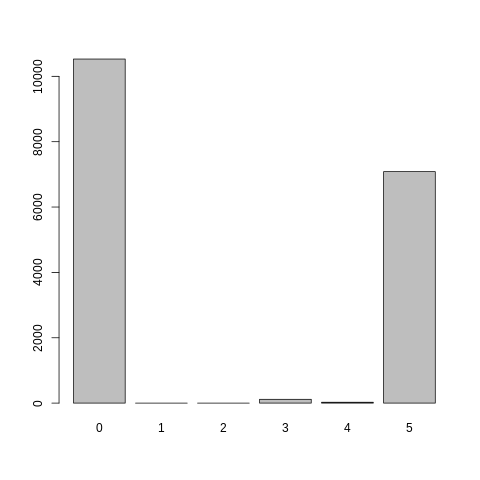

In [0]:
%%R
plot(prediction)

**Having in the last histogram "0 = very negative customer review, and 5 is very positive customer review", then the prediction indicates that there are above 10,000 very negative reviews about Samsung Galaxy, and at the same time, there are above 7,000 very positive reviews. Only few reviews were centered around good & positive reviews**